# FIT5149 S2 2019 
## Assessment 1: 
## Predicting Critical Temperature 


Student information
- Family Name: Diwe
- Given Name: Shubham 
- Student ID: 29329604
- Student email: sdiw0001@student.monash.edu

Programming Language: R 3.5.1 in Jupyter Notebook

R Libraries used:
- ISLR
- glmnet
- ggplot2
- reshape2
- dplyr
- leaps
- caret
- psych
- GGally

## Table of Contents

* [Introduction](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development](#sec_3)
* [Model Comparison](#sec_4)
* [Conclusion](#sec_5)
* [References](#sec_6)

## Libraries Import

In [1]:
r = getOption("repos")                       
r["CRAN"] = "http://cran.us.r-project.org"   
options(repos = r, warn = -1)

In [2]:
options(warn = -1)

library(reshape2)
library(glmnet)
library(leaps)
library(car)
library(dplyr)
library(ISLR)
library(ggplot2)
library(GGally)
library(gridExtra)
library(cowplot)
library(stats)
library(lattice)
library(psych)
library(caret)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: carData

Attaching package: 'dplyr'

The following object is masked from 'package:car':

    recode

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'GGally'

The following object is masked from 'package:dplyr':

    nasa


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha

The following object is masked from 'pac

## 1. Introduction <a class="anchor" id="sec_1"></a>

#### The files train.csv and unique_m.csv contain the following data

- We are given the data different compounds with their chemical composition
- Various properties of each compound like atomic weighs, valency, etc. are provided
- The task is to predict the Critical Temperature from the given information
- In short, we have to find a relationship between properties of materials and superconductivity
- Exploratory and statistical methods are employed to find if such a relationship exists 

In [3]:
data <- read.csv('train.csv')
head(data)

number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
4,88.94447,57.86269,66.36159,36.11661,1.181795,1.0623955,122.9061,31.79492,51.96883,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.4330127,0.4370588,29
5,92.72921,58.51842,73.13279,36.39660,1.449309,1.0577551,122.9061,36.16194,47.09463,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.6324555,0.4686063,26
4,88.94447,57.88524,66.36159,36.12251,1.181795,0.9759805,122.9061,35.74110,51.96883,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.4330127,0.4446966,19
4,88.94447,57.87397,66.36159,36.11956,1.181795,1.0222909,122.9061,33.76801,51.96883,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.4330127,0.4409521,22
4,88.94447,57.84014,66.36159,36.11072,1.181795,1.1292237,122.9061,27.84874,51.96883,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.4330127,0.4288095,23
4,88.94447,57.79504,66.36159,36.09893,1.181795,1.2252028,122.9061,20.68746,51.96883,...,2.214286,2.213364,2.181543,1.368922,1.141474,1,1.000000,0.4330127,0.4103259,23


In [4]:
elem.comp <- read.csv('unique_m.csv')
head(elem.comp)

H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,29,Ba0.2La1.8Cu1O4
0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,26,Ba0.1La1.9Ag0.1Cu0.9O4
0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,19,Ba0.1La1.9Cu1O4
0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,22,Ba0.15La1.85Cu1O4
0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,23,Ba0.3La1.7Cu1O4
0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,23,Ba0.5La1.5Cu1O4


- **Creating the training and testing data sets**

    - Split the data into two parts in the ratio 70%-30%
    - We use the 70% set to train the models and the 30% set to check model predictions

In [5]:
R <- dim(data)[1]
C <- dim(data)[2]

set.seed(12345)

R.train <- round((R * 0.7), digits = 0)
train.index <- sort(sample(x = nrow(data), size = R.train))

train.data <- data[train.index, ]
test.data <- data[-train.index, ]

dim(train.data)
dim(test.data)

[1] 14884    82

[1] 6379   82

## 2. Data Exploration<a class="anchor" id="sec_2"></a>

- Let us explore the data sets first by looking at the first few rows and their structure

In [6]:
names(data)

[1] "number_of_elements"              "mean_atomic_mass"               
 [3] "wtd_mean_atomic_mass"            "gmean_atomic_mass"              
 [5] "wtd_gmean_atomic_mass"           "entropy_atomic_mass"            
 [7] "wtd_entropy_atomic_mass"         "range_atomic_mass"              
 [9] "wtd_range_atomic_mass"           "std_atomic_mass"                
[11] "wtd_std_atomic_mass"             "mean_fie"                       
[13] "wtd_mean_fie"                    "gmean_fie"                      
[15] "wtd_gmean_fie"                   "entropy_fie"                    
[17] "wtd_entropy_fie"                 "range_fie"                      
[19] "wtd_range_fie"                   "std_fie"                        
[21] "wtd_std_fie"                     "mean_atomic_radius"             
[23] "wtd_mean_atomic_radius"          "gmean_atomic_radius"            
[25] "wtd_gmean_atomic_radius"         "entropy_atomic_radius"          
[27] "wtd_entropy_atomic_radius"       "range_atomic_radius"            
[29] "wtd_range_atomic_radius"         "std_atomic_radius"              
[31] "wtd_std_atomic_radius"           "mean_Density"                   
[33] "wtd_mean_Density"                "gmean_Density"                  
[35] "wtd_gmean_Density"               "entropy_Density"                
[37] "wtd_entropy_Density"             "range_Density"                  
[39] "wtd_range_Density"               "std_Density"                    
[41] "wtd_std_Density"                 "mean_ElectronAffinity"          
[43] "wtd_mean_ElectronAffinity"       "gmean_ElectronAffinity"         
[45] "wtd_gmean_ElectronAffinity"      "entropy_ElectronAffinity"       
[47] "wtd_entropy_ElectronAffinity"    "range_ElectronAffinity"         
[49] "wtd_range_ElectronAffinity"      "std_ElectronAffinity"           
[51] "wtd_std_ElectronAffinity"        "mean_FusionHeat"                
[53] "wtd_mean_FusionHeat"             "gmean_FusionHeat"               
[55] "wtd_gmean_FusionHeat"            "entropy_FusionHeat"             
[57] "wtd_entropy_FusionHeat"          "range_FusionHeat"               
[59] "wtd_range_FusionHeat"            "std_FusionHeat"                 
[61] "wtd_std_FusionHeat"              "mean_ThermalConductivity"       
[63] "wtd_mean_ThermalConductivity"    "gmean_ThermalConductivity"      
[65] "wtd_gmean_ThermalConductivity"   "entropy_ThermalConductivity"    
[67] "wtd_entropy_ThermalConductivity" "range_ThermalConductivity"      
[69] "wtd_range_ThermalConductivity"   "std_ThermalConductivity"        
[71] "wtd_std_ThermalConductivity"     "mean_Valence"                   
[73] "wtd_mean_Valence"                "gmean_Valence"                  
[75] "wtd_gmean_Valence"               "entropy_Valence"                
[77] "wtd_entropy_Valence"             "range_Valence"                  
[79] "wtd_range_Valence"               "std_Valence"                    
[81] "wtd_std_Valence"                 "critical_temp"

In [7]:
dim(data)

[1] 21263    82

In [8]:
str(data)

'data.frame':	21263 obs. of  82 variables:
 $ number_of_elements             : int  4 5 4 4 4 4 4 4 4 4 ...
 $ mean_atomic_mass               : num  88.9 92.7 88.9 88.9 88.9 ...
 $ wtd_mean_atomic_mass           : num  57.9 58.5 57.9 57.9 57.8 ...
 $ gmean_atomic_mass              : num  66.4 73.1 66.4 66.4 66.4 ...
 $ wtd_gmean_atomic_mass          : num  36.1 36.4 36.1 36.1 36.1 ...
 $ entropy_atomic_mass            : num  1.18 1.45 1.18 1.18 1.18 ...
 $ wtd_entropy_atomic_mass        : num  1.062 1.058 0.976 1.022 1.129 ...
 $ range_atomic_mass              : num  123 123 123 123 123 ...
 $ wtd_range_atomic_mass          : num  31.8 36.2 35.7 33.8 27.8 ...
 $ std_atomic_mass                : num  52 47.1 52 52 52 ...
 $ wtd_std_atomic_mass            : num  53.6 54 53.7 53.6 53.6 ...
 $ mean_fie                       : num  775 766 775 775 775 ...
 $ wtd_mean_fie                   : num  1010 1011 1011 1011 1010 ...
 $ gmean_fie                      : num  718 721 718 718 718 ...
 $

In [9]:
dim(elem.comp)

[1] 21263    88

In [10]:
names(elem.comp)

[1] "H"             "He"            "Li"            "Be"           
 [5] "B"             "C"             "N"             "O"            
 [9] "F"             "Ne"            "Na"            "Mg"           
[13] "Al"            "Si"            "P"             "S"            
[17] "Cl"            "Ar"            "K"             "Ca"           
[21] "Sc"            "Ti"            "V"             "Cr"           
[25] "Mn"            "Fe"            "Co"            "Ni"           
[29] "Cu"            "Zn"            "Ga"            "Ge"           
[33] "As"            "Se"            "Br"            "Kr"           
[37] "Rb"            "Sr"            "Y"             "Zr"           
[41] "Nb"            "Mo"            "Tc"            "Ru"           
[45] "Rh"            "Pd"            "Ag"            "Cd"           
[49] "In"            "Sn"            "Sb"            "Te"           
[53] "I"             "Xe"            "Cs"            "Ba"           
[57] "La"            "Ce"            "Pr"            "Nd"           
[61] "Pm"            "Sm"            "Eu"            "Gd"           
[65] "Tb"            "Dy"            "Ho"            "Er"           
[69] "Tm"            "Yb"            "Lu"            "Hf"           
[73] "Ta"            "W"             "Re"            "Os"           
[77] "Ir"            "Pt"            "Au"            "Hg"           
[81] "Tl"            "Pb"            "Bi"            "Po"           
[85] "At"            "Rn"            "critical_temp" "material"

In [11]:
head(str(elem.comp))

'data.frame':	21263 obs. of  88 variables:
 $ H            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ He           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Li           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Be           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ B            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ C            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ O            : num  4 4 4 4 4 4 4 4 4 4 ...
 $ F            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Ne           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Na           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Mg           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Al           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Si           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ P            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ S            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cl           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Ar           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ K            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Ca           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Sc           :

NULL

### ***As per the problem description, there are 8 properties with 10 features for each property***

   * So, let us consider the correlation of these 8 features
   - We will use the mean of these features and the target variable
   - From this analysis, we try to find the relationship between the features and target variable

[1]  2 12 22 32 42 52 62 72 82

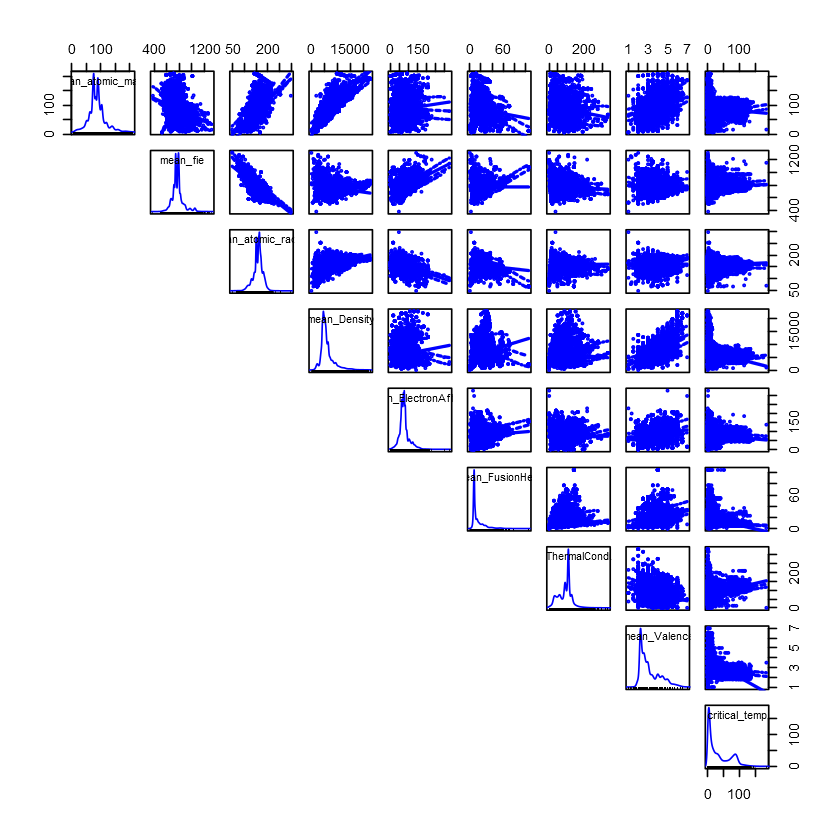

In [12]:
means.cols <- seq(2, 82, 10)
means.cols

means.data <- data[, c(means.cols)]

scatterplotMatrix(data[, c(means.cols)], cex = 0.2, lower.panel = NULL)

In [13]:
means.cor <- cor(means.data) 
means.cor

,mean_atomic_mass,mean_fie,mean_atomic_radius,mean_Density,mean_ElectronAffinity,mean_FusionHeat,mean_ThermalConductivity,mean_Valence,critical_temp
mean_atomic_mass,1.00000000,-0.285781955,0.49766363,0.7568611,0.08822954,-0.137668902,-0.15826564,0.37409881,-0.1135232
mean_fie,-0.28578196,1.000000000,-0.69031861,-0.1944060,0.46697221,-0.001012562,-0.06780451,-0.10974859,0.1022681
mean_atomic_radius,0.49766363,-0.690318608,1.00000000,0.3692764,-0.36773846,-0.144850048,0.02844322,0.05257839,0.1052727
mean_Density,0.75686112,-0.194405997,0.36927643,1.0000000,0.13281700,0.264720166,-0.07385540,0.70964054,-0.3682618
mean_ElectronAffinity,0.08822954,0.466972210,-0.36773846,0.1328170,1.00000000,0.104044662,-0.01537427,0.32121600,-0.1935505
mean_FusionHeat,-0.13766890,-0.001012562,-0.14485005,0.2647202,0.10404466,1.000000000,-0.04014108,0.48812272,-0.3855093
mean_ThermalConductivity,-0.15826564,-0.067804508,0.02844322,-0.0738554,-0.01537427,-0.040141080,1.00000000,-0.35591237,0.3758129
mean_Valence,0.37409881,-0.109748588,0.05257839,0.7096405,0.32121600,0.488122722,-0.35591237,1.00000000,-0.6000849
critical_temp,-0.11352325,0.102268054,0.10527269,-0.3682618,-0.19355049,-0.385509259,0.37581286,-0.60008486,1.0000000


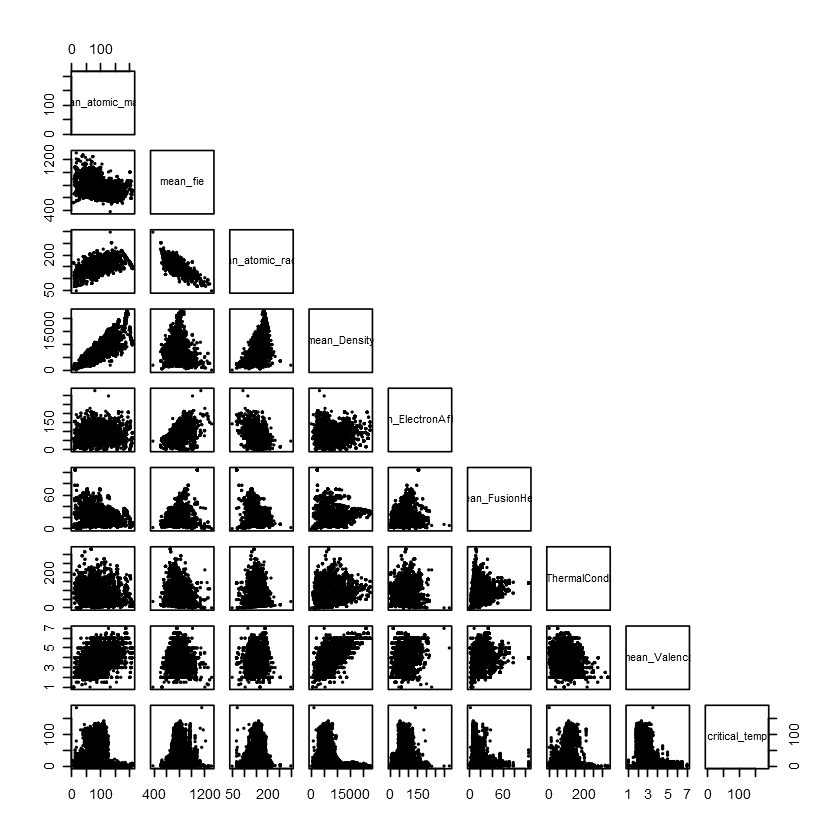

In [14]:
##### Use the below command only if the scatterplotMatrix is taking too long
pairs(means.data, upper.panel = NULL, cex = 0.1)

**If we focus on the bottom row plots, we find that almost all the attributes are normally distributed w.r.t. the critical temperature.**
   - There is skewness in some of them, for example, Electron Affinity is right skewed.
   - But, in all the cases, the distribution resembles a normal curve.
   
**From the above plots and matrix, we can see that the variables mean_atomic_mass and mean_density are highly correlated**
   - This is logical as: Density (${\rho}$) = Mass (M) / Volume (V) 
   
**Another variable, mean_valence is also highly correlated with mean_density**

In [15]:
means.cor[(means.cor > 0.7 & means.cor < 1)]

[1] 0.7568611 0.7568611 0.7096405 0.7096405

#### Total Correlation
- **Let us see the variables which are highly correlated in the entire data set**
    - Correlated variables contain the same or similar information about the data
    - So, there is no point in having the all the correlated variables in the model
    - Instead we can reduce the features in the model by considering only one of the highly correlated variables
    - Hence, we find the correlation coefficients for each pair and then remove these pairs from the data    

In [16]:
data.cor <- cor(data[, -c(82)])

# Variables with correlation greater than 90%
high.cor90 <- findCorrelation(data.cor, cutoff = 0.9)
high.cor90

# Variables with correlation greater than 80%
high.cor80 <- findCorrelation(data.cor, cutoff = 0.8)
high.cor80

# Variables with correlation greater than 75%
high.cor75 <- findCorrelation(data.cor, cutoff = 0.75)
high.cor75

[1] 18 21 27 28 31 76 77 16 35  1 26 68 75 73  6 71 25 72 56 13  8  5 55 54 11
[26] 48 53  4 24 41 40 14 61 58 80

[1] 18 21 27 28 31 76 77 16 20  7 35  1 26 34 68 75 73  6 71 57 25 72 46 56 13
[26] 33  8 23  5 36 17 55 54 11 64 48 51 53  3  4 24  9 38 43 12 40 42 61 58 63
[51] 81 80

[1] 18 21 27 28 31 76 77 16 20  7 35  1 26 34 68 75 73  6 71 57 25 72 46 56 13
[26] 33  8 23  5 36 17 55 54 11 64 32 48 51 53  3  4 24  9 38 43 12 67 40 42 61
[51] 58 63 81 80

In [17]:
print(names(train.data[, -c(high.cor90, 82)]))

 [1] "mean_atomic_mass"                "wtd_mean_atomic_mass"           
 [3] "wtd_entropy_atomic_mass"         "wtd_range_atomic_mass"          
 [5] "std_atomic_mass"                 "mean_fie"                       
 [7] "wtd_gmean_fie"                   "wtd_entropy_fie"                
 [9] "wtd_range_fie"                   "std_fie"                        
[11] "mean_atomic_radius"              "wtd_mean_atomic_radius"         
[13] "wtd_range_atomic_radius"         "std_atomic_radius"              
[15] "mean_Density"                    "wtd_mean_Density"               
[17] "gmean_Density"                   "entropy_Density"                
[19] "wtd_entropy_Density"             "range_Density"                  
[21] "wtd_range_Density"               "mean_ElectronAffinity"          
[23] "wtd_mean_ElectronAffinity"       "gmean_ElectronAffinity"         
[25] "wtd_gmean_ElectronAffinity"      "entropy_ElectronAffinity"       
[27] "wtd_entropy_ElectronAffinity"    "wtd_range_E

- **Apparently, the number of elements is also highly correlated with some variables and affects the feature set**

In [18]:
data.cor[(data.cor > 0.9 & data.cor != 1)]

[1] 0.9393041 0.9731953 0.9722452 0.9041207 0.9007593 0.9678325 0.9402982
  [8] 0.9640851 0.9402982 0.9640851 0.9393041 0.9646946 0.9723288 0.9326682
 [15] 0.9282509 0.9636211 0.9614639 0.9182844 0.9608542 0.9181524 0.9608542
 [22] 0.9197877 0.9181524 0.9197877 0.9693245 0.9923311 0.9693245 0.9923311
 [29] 0.9731953 0.9646946 0.9977394 0.9201925 0.9020373 0.9128622 0.9165921
 [36] 0.9927256 0.9079231 0.9816283 0.9402813 0.9087344 0.9816283 0.9342550
 [43] 0.9402813 0.9342550 0.9222584 0.9159314 0.9801072 0.9159314 0.9801072
 [50] 0.9722452 0.9723288 0.9977394 0.9142226 0.9155502 0.9097440 0.9302940
 [57] 0.9895461 0.9041207 0.9614639 0.9201925 0.9142226 0.9078598 0.9191839
 [64] 0.9514635 0.9087344 0.9674282 0.9580035 0.9674282 0.9445362 0.9222584
 [71] 0.9580035 0.9445362 0.9415016 0.9519949 0.9415016 0.9519949 0.9326682
 [78] 0.9020373 0.9155502 0.9177321 0.9005791 0.9599556 0.9073073 0.9599556
 [85] 0.9056694 0.9073073 0.9056694 0.9128622 0.9097440 0.9046594 0.9731145
 [92] 0.9731145 0.9095746 0.9267688 0.9095746 0.9709481 0.9267688 0.9709481
 [99] 0.9007593 0.9282509 0.9165921 0.9302940 0.9177321 0.9214447 0.9078598
[106] 0.9087280 0.9845736 0.9256421 0.9845736 0.9401833 0.9256421 0.9401833
[113] 0.9878666 0.9654488 0.9878666 0.9556271 0.9654488 0.9556271 0.9371029
[120] 0.9899105 0.9400013 0.9371029 0.9179052 0.9949388 0.9899105 0.9179052
[127] 0.9330357 0.9400013 0.9949388 0.9330357 0.9678325 0.9636211 0.9927256
[134] 0.9895461 0.9191839 0.9005791 0.9046594 0.9214447 0.9108218 0.9182844
[141] 0.9079231 0.9514635 0.9087280 0.9108218 0.9737879 0.9737879

In [19]:
up.data.cor <- data.cor
up.data.cor[lower.tri(data.cor, diag = T)] <- NA
dim(subset(melt(up.data.cor), value > 0.90 & value != 1))

[1] 73  3

In [20]:
cor.target <- sapply(1:81, function(i) {cor(x = data[, c(i)], y = data[, c(82)])})

In [21]:
top10 <- sort(tail(cor.target, 10))
top10

btm10 <- sort(head(cor.target, 10))
btm10

[1] -0.6324010 -0.6156533 -0.6000849 -0.5730681 -0.4399008 -0.3000280
 [7] -0.2080716 -0.1435464  0.5896637  0.5985909

[1] -0.3698584 -0.3371314 -0.3122720 -0.2303454 -0.1135232  0.3787658
 [7]  0.4919698  0.5436194  0.6010686  0.6269304

In [22]:
cols.top <- match(c(top10), cor.target)
names(data[, c(cols.top)])

cols.btm <- match(c(btm10), cor.target)
names(data[, c(cols.btm)])

[1] "wtd_mean_Valence"    "wtd_gmean_Valence"   "mean_Valence"       
 [4] "gmean_Valence"       "wtd_range_Valence"   "wtd_std_Valence"    
 [7] "std_Valence"         "range_Valence"       "wtd_entropy_Valence"
[10] "entropy_Valence"

[1] "wtd_gmean_atomic_mass"   "wtd_range_atomic_mass"  
 [3] "wtd_mean_atomic_mass"    "gmean_atomic_mass"      
 [5] "mean_atomic_mass"        "std_atomic_mass"        
 [7] "range_atomic_mass"       "entropy_atomic_mass"    
 [9] "number_of_elements"      "wtd_entropy_atomic_mass"

* **From the above results, it is evident that the valency affects the critical temperature a lot.**
* **So, it must be included as a feature in our models and given considerable weights.**

[1] 0.6010686

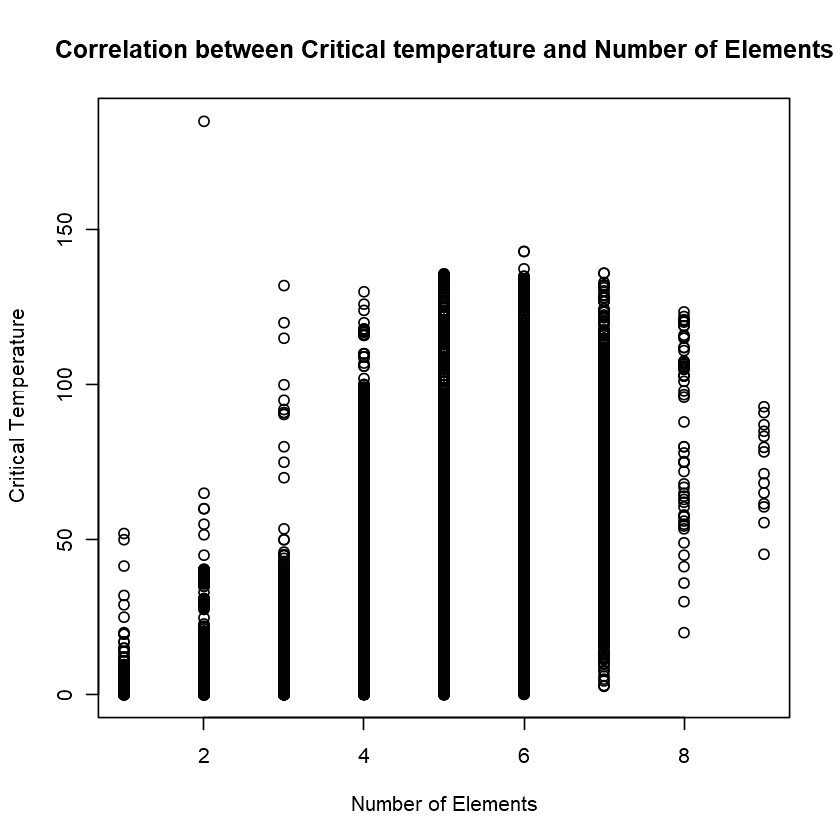

In [23]:
plot(x = data[, 1], y = data[, 82], main = 'Correlation between Critical temperature and Number of Elements',
    xlab = 'Number of Elements', ylab = 'Critical Temperature')

cor(x = data[, 1], y = data[, 82])

- From the above plot, there appears to be slightly positive correlation between the number of elements in the compound and the critical temperature

#### The thermal conductivity feature, especially the geometric mean of the thermal conductivity appears to show a inverse squared relationship with the critical temperature.
   - Let us take a closer look at these features and how they behave with each other.
   - An interesting point to note is that among the given features, Thermal conductivity is the only preoperty with the unit of temperature (Kelvin) as its dimensional unit.
   - The units of thermal conductivity are: $ H_c\ =\ \frac{Watt}{Kelvin-meter} $ 

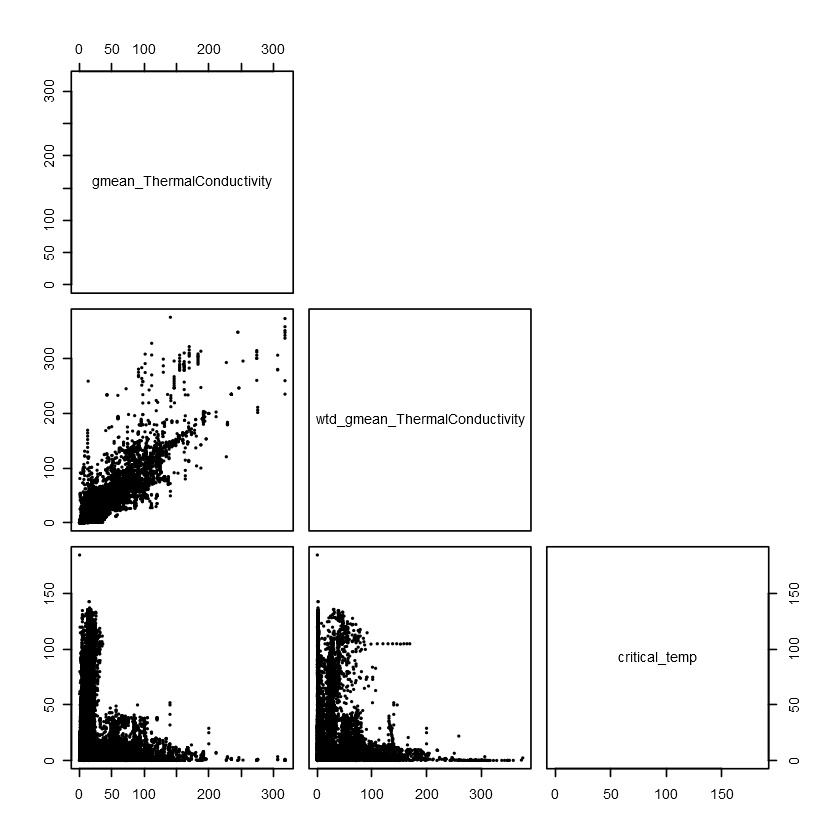

In [24]:
pairs(data[, c(64, 65, 82)], upper.panel = NULL, cex = 0.1)

- **Let us find the correlation between various variables and find the ones which can be omitted as input features**
    - Plot the correlations as a levelplot to inspect and filter features

In [25]:
wen.cols <- seq(7, 77, 10)

wen.data <- data[, c(wen.cols, 82)]

wen.cor <- cor(wen.data)

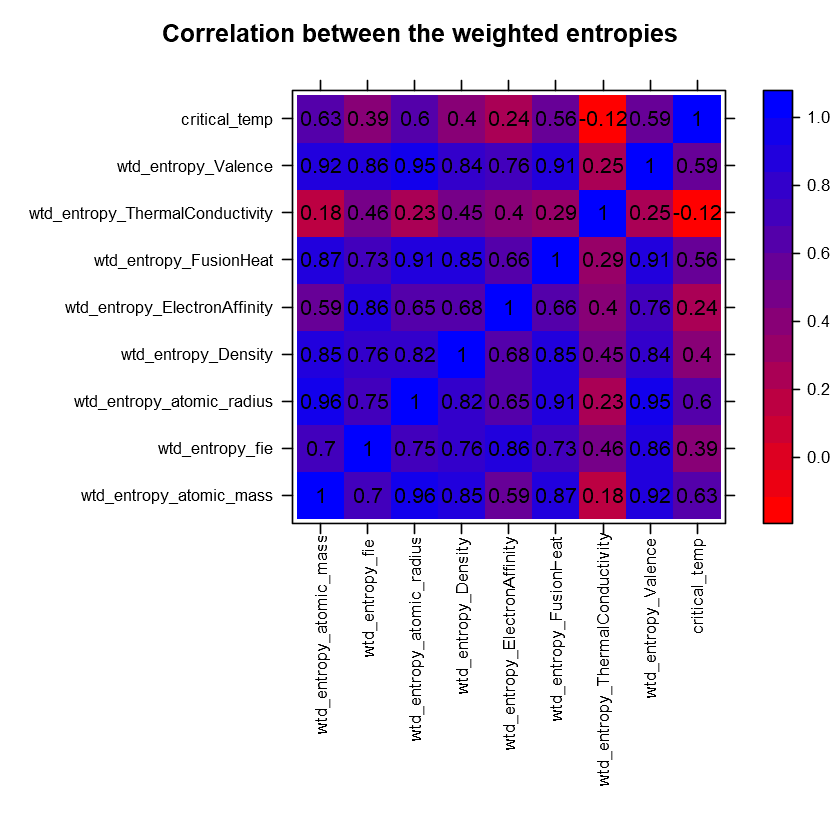

In [26]:
#### Function from tutorial 3 to create the coloring panel
myPanel <- function(x, y, z, ...) {
    panel.levelplot(x,y,z,...)
    panel.text(x, y, round(z, 2))
}

#Define the color scheme from the tutorial 3 
cols = colorRampPalette(c("red","blue"))

levelplot(wen.cor, col.regions = cols(100), main = 'Correlation between the weighted entropies', xlab = NULL,
         ylab = NULL, scales = list(x = list(rot = 90)), panel = myPanel)

#### From the above level plot, it appears that the weighted entropies are highly correlated with each other, especially the weighted entropy of valency.
- This tells us that when we are considering entropy of valency, we may choose to ignore most other weighted entropies

### Based on the above observations, we now will start building a model and try to find the most suitable features for prediction of critical temperature

## 3. Model Development<a class="anchor" id="sec_3"></a>

#### Scientifically speaking, if we assume that the critical temperature of a material is linked to the features we have in this data set and is based on a formula, then only one or two terms of each property should be considered as it doesn't make sense that the critical temerature depends on the valency and standard deviation of the valency as well. 
- So, we will start with a feature selection model like Lasso regression
- The important task here is to analyse which models with what input features gives us more accuracy

### 1. Lasso Regression:
* L1 Norm: To select important input features while predicting and for other models
    - We have a large number of input variables; 81 to be precise. 
    - Some are highly correlated so only one of them can be selected. 
    - However, which ones to select is a challenge as we cannot go through comparisons for each variable.
    - Lasso (L1 Norm) Regression provides sparse solution to problems. So, it is an ideal selection for this task.
    - The input features selected by Lasso can be used for other models like KNN, Logistic Regression.
    - This in turn might improve the accuracy of the pedictions.
    - Hence, it is best to implement Lasso as the first model and perform feature selection.

In [27]:
input.x <- as.matrix(train.data[, -c(82)])
target.y <- train.data[, c(82)]

In [28]:
set.seed(12345)
x.mat <- model.matrix(target.y ~ input.x, data = train.data)
x.mat <- x.mat[, -c(1)]

* **We use cross-validation to generalize the selected features**
    - It is important that the selected features are generalized and not a result of some bias or initialization
    - Cross-validation helps ensure generalization and gives the performance on a sample test set

In [29]:
cv.lasso <- cv.glmnet(x.mat, target.y, alpha = 1)

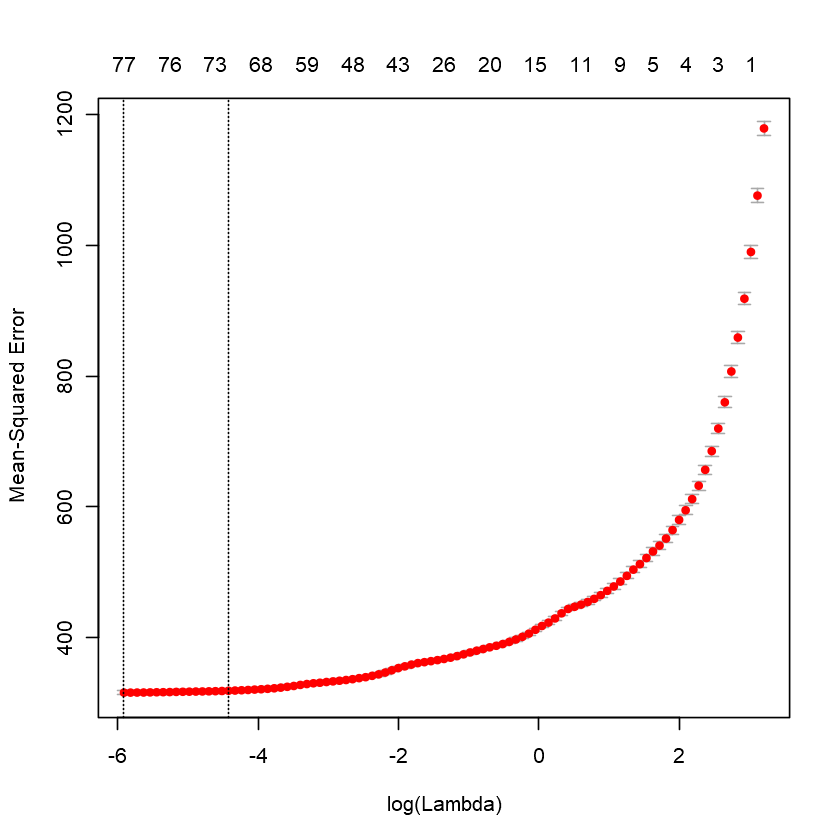

In [30]:
plot(cv.lasso)

In [31]:
bestlam <- cv.lasso$lambda.min
bestlam

[1] 0.002711746

In [32]:
fit.lasso <- glmnet(x.mat, target.y, alpha = 1)
lasso.coef <- predict(fit.lasso, s = bestlam, type = "coefficients")[1:81, ]
# lasso.coef

In [33]:
names(lasso.coef[lasso.coef == 0])

[1] "input.xwtd_gmean_fie"         "input.xentropy_atomic_radius"
[3] "input.xwtd_mean_Valence"      "input.xstd_Valence"

In [34]:
lasso.pred <- predict(fit.lasso, s = bestlam, type = "response", newx = as.matrix(test.data[, -c(82)]))

In [35]:
mse.lasso <- mean((lasso.pred - test.data[, 82])^2)
mse.lasso

[1] 304.6587

In [36]:
rmse.lasso <- sqrt(mse.lasso)
rmse.lasso

[1] 17.45448

- **From the above analysis, we can surely avoid the 4 features in our future prediction models**
- We can also remove the features with very very low values of their coefficients.
- This is to just reduce the input feature dimensionality.

In [37]:
length(lasso.coef[(lasso.coef > 0.5) | (lasso.coef < -0.5)])
names(lasso.coef[(lasso.coef > 0.5) | (lasso.coef < -0.5)])

[1] 35

[1] "(Intercept)"                           
 [2] "input.xnumber_of_elements"             
 [3] "input.xentropy_atomic_mass"            
 [4] "input.xwtd_entropy_atomic_mass"        
 [5] "input.xentropy_fie"                    
 [6] "input.xwtd_entropy_fie"                
 [7] "input.xmean_atomic_radius"             
 [8] "input.xwtd_mean_atomic_radius"         
 [9] "input.xgmean_atomic_radius"            
[10] "input.xwtd_gmean_atomic_radius"        
[11] "input.xwtd_entropy_atomic_radius"      
[12] "input.xstd_atomic_radius"              
[13] "input.xentropy_Density"                
[14] "input.xwtd_entropy_Density"            
[15] "input.xwtd_mean_ElectronAffinity"      
[16] "input.xwtd_gmean_ElectronAffinity"     
[17] "input.xentropy_ElectronAffinity"       
[18] "input.xwtd_entropy_ElectronAffinity"   
[19] "input.xstd_ElectronAffinity"           
[20] "input.xwtd_std_ElectronAffinity"       
[21] "input.xmean_FusionHeat"                
[22] "input.xwtd_mean_FusionHeat"            
[23] "input.xgmean_FusionHeat"               
[24] "input.xwtd_gmean_FusionHeat"           
[25] "input.xentropy_FusionHeat"             
[26] "input.xwtd_entropy_FusionHeat"         
[27] "input.xentropy_ThermalConductivity"    
[28] "input.xwtd_entropy_ThermalConductivity"
[29] "input.xmean_Valence"                   
[30] "input.xgmean_Valence"                  
[31] "input.xwtd_gmean_Valence"              
[32] "input.xentropy_Valence"                
[33] "input.xwtd_entropy_Valence"            
[34] "input.xrange_Valence"                  
[35] "input.xwtd_range_Valence"

#### As the Lasso (L1 Norm) did not reduce the dimensionality sufficiently, we need to use an Autoencoder
#### If not, then we need to come up with a manual model with features selected based on some scientific theory and data observations or findings from exploration

### 2. KNN Regressor:
- **Now we try using a KNN Regressor for which the input features are selected based on scientific researches**
    - Based on observations and referencing Wikipedia, we filter a set of input features which we think to affect the critical temperature.
    - A KNN-regressor predicts a value which is closest to values observed in the training set.
    - The assumption is that materials with similar properties like atomic mass, valency, entropy, etc. may have similar critical temperatures.
    - KNN Regressor finds the features in the training set which closest to the features of the test set and then assigns a value to the test prediction.

* **Below is the correlation of each property with the critical temperature**
* **Since we are trying to predict the critical temperature, we must try to maximize this correlation** 
    - It is known that correlation does not imply causation but we can still give this a try as we are not finding the reason or formula for the critical temperature here but a way to determine the critical temperature 
    
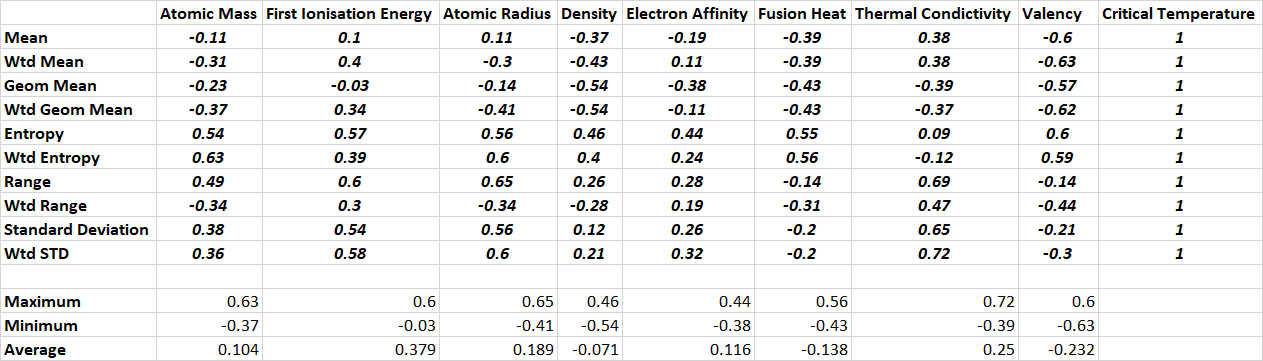

**Assumption: We have just 8 unique properties and 10 attributes for each property. It is assumed that the critical temperature is dependent on each of the property and the one of the ten attribute from that property is the one that helps in prediction**

In [38]:
max.cor.in <- c('number_of_elements','wtd_entropy_atomic_mass', 'range_fie', 'range_atomic_radius', 'wtd_gmean_Density', 
                'entropy_ElectronAffinity', 'wtd_entropy_FusionHeat', 'wtd_std_ThermalConductivity', 'mean_Valence')

input.knn <- train.data[, c(max.cor.in)]

* **Note 1: We consider the number of elements here, as in the correlation plot, a slightly positive correlation is seen between number of elements and critical temperature.**
* **Note 2: Though the absolute value of correlation between valency and correlation is maximum in weighted mean valency, from the Lasso model, we get that the coefficient for the same is reduced to 0. So, we consider the next best correlated attribute which is mean valency.**

- **As with any KNN model, now we need to find the optimum value of K for the closest neighbours to be considered**
    - To reduce computation time and get a rough idea about the location of best K, we first consider the range K = [2, 10]

In [39]:
mse.train = vector()
mse.test = vector()
K <- seq(2, 10, 1)

for (i in 2:10) {
    
    knn.i <- knnreg(x = input.knn, y = train.data[, 82], k = i, use.all = T)
    
    knn.i.train <- predict(knn.i, train.data[, c(max.cor.in)])
    
    knn.i.test <- predict(knn.i, test.data[, c(max.cor.in)])
    
    mse.train[i-1] <- mean((knn.i.train - train.data[, 82])^2)
    
    mse.test[i-1] <- mean((knn.i.test - test.data[, 82])^2)
    
}

In [40]:
K
mse.train
mse.test

error.knn <- cbind(K, mse.train, mse.test)

[1]  2  3  4  5  6  7  8  9 10

[1]  73.90403 100.47332 119.09501 135.45741 145.80856 155.11809 163.87467
[8] 170.51055 177.40382

[1] 213.5107 205.4920 203.5092 207.9254 206.9938 209.6318 214.4659 216.9909
[9] 220.8052

In [41]:
colnames(error.knn) <- c('K', 'TrainError', 'TestError')

error.knn.m <- melt(error.knn, id = 'K')
names(error.knn.m) <- c('K', 'type', 'error') 
error.knn.m <- error.knn.m[10:27, ]

In [42]:
error.knn.m[, 'K'] <- rep(seq(2, 10, 1), 2)
# error.knn.m

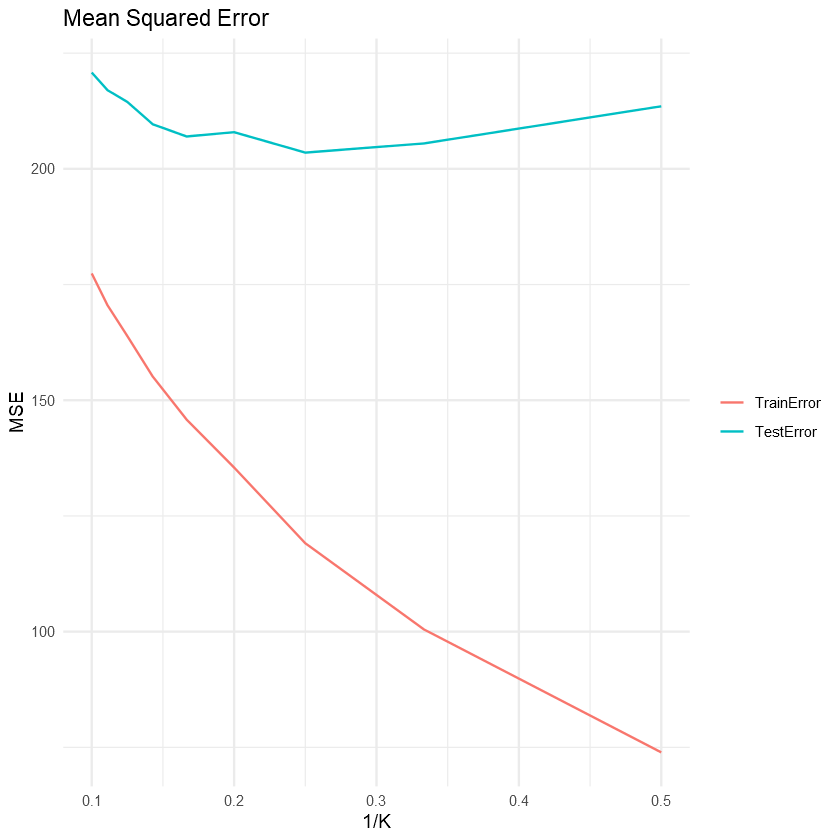

In [43]:
knn.plt <- ggplot(data=error.knn.m, aes(x=(1/K), y=error, color=type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("Mean Squared Error") + ylab('MSE') + xlab('1/K')
print(knn.plt)

**The minimum test error is observed for K = 4**

In [44]:
fit.knn <- knnreg(x = input.knn, y = train.data[, 82], k = 4, use.all = T)

In [45]:
knn.pred <- predict(fit.knn, test.data[, c(max.cor.in)])

In [46]:
mse.knn <- mean((knn.pred - test.data[, 82])^2)
mse.knn

[1] 203.5092

In [47]:
rmse.knn <- sqrt(mse.knn)
rmse.knn

[1] 14.26566

#### **Apparently, in this case, this selection of inputs with KNN works better than the Lasso regression**
   - Here we have manually selected the input variables which had the maximum absolute correlation with the target.
   - The mean squared error or the KNN Regressor is less than the mean squared error of the Lasso regressor.
   - One drawback of this approach is that it is difficult to establish a relationship/formula for the target from this result.

### 3. Simple Linear Regression Model:
- **Here, we will implement a simple linear regression model using the same input features as in the KNN.**
    - The input features obtained above show a promising outcome for the prediction task.
    - Now, we will implement the linear regression and teh Lasso regression while giving input as these features.
    - This way, we can compare the output of the KNN with linear regression models.

In [48]:
input.lm <- train.data[ , c(max.cor.in, 'critical_temp')]

In [49]:
fit.lm <- lm(critical_temp ~ ., input.lm)

In [50]:
lm.pred <- predict(fit.lm, test.data[, c(max.cor.in)])

In [51]:
mse.lm <- mean((lm.pred - test.data[, 82])^2)
mse.lm

[1] 445.878

In [52]:
rmse.lm <- sqrt(mse.lm)
rmse.lm

[1] 21.11582

#### A simple linear regression is not a very good fit for the given model as the mean squared error is twice of the one obtained using KNN.
   - This linear regression model performs the worst amongst all the models tried so far.
   - This model has the same input features as in the KNN, i.e, the features with maximum correlation with the target
   - So, this clearly indicated that there is no linear relationship between the observed properties and the target.

### 4: Scientific Model (Non-Linear analysis):
* **In this model, we will use the units of each of the observed properties and the units of the target variable**
    - We will come up with a possible scientific relationship between the variables and the target.
    - With this relationship, we will create a formula for calculating the target.
    - Then, we will input this as the relation for the linear model. 
    - the features selected here will be either the means or the ones with highest correlation with the target.

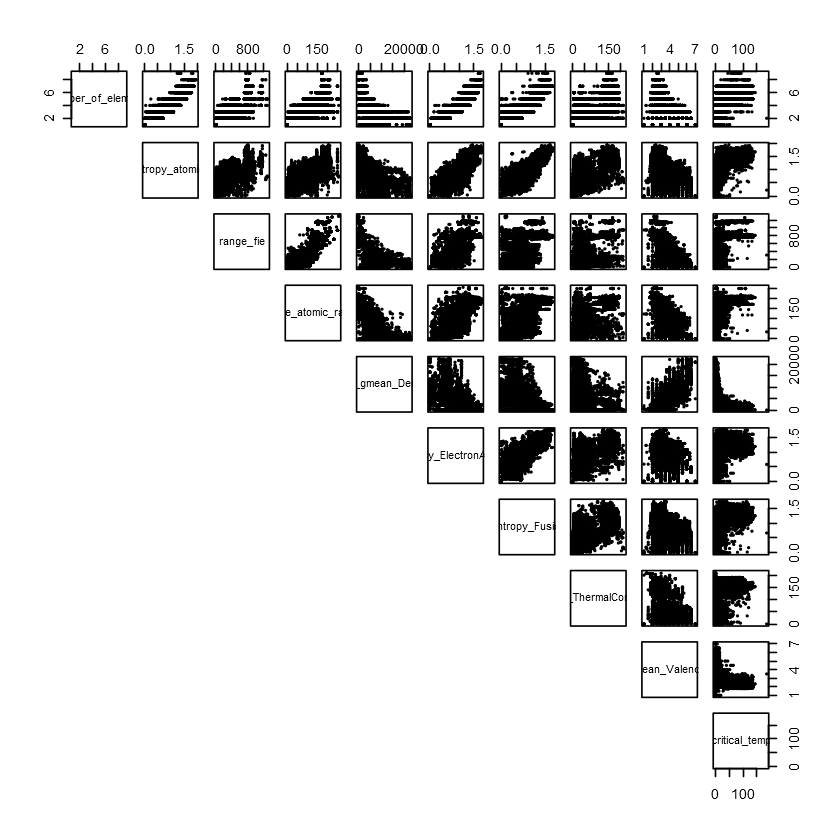

In [53]:
pairs(data[, c(max.cor.in, 'critical_temp')], cex = 0.1, lower.panel = NULL)

In [54]:
numerator <- (data$number_of_elements * data$wtd_gmean_Density * data$range_fie * data$entropy_ElectronAffinity)
denominator <- (data$wtd_entropy_atomic_mass * data$range_atomic_radius * data$wtd_entropy_FusionHeat * 
               data$wtd_std_ThermalConductivity * data$mean_Valence)

In [55]:
denominator[(denominator == 0)] <- mean(denominator)
length(denominator[denominator == 0])

formula <- numerator / denominator

formula[formula == 0] <- mean(formula)

head(formula)
length(formula)

[1] 0

[1] 2.981041 4.818128 3.508594 3.210052 2.649666 2.259525

[1] 21263

In [56]:
df.formula <- as.data.frame(cbind(formula, data[, 82]))
colnames(df.formula) <- c('formula', 'TC')

df <- na.omit(df.formula)

dim(df)

head(df)

summary(df)

[1] 21263     2

formula,TC
2.981041,29
4.818128,26
3.508594,19
3.210052,22
2.649666,23
2.259525,23


    formula               TC           
 Min.   :0.00e+00   Min.   :  0.00021  
 1st Qu.:3.00e+00   1st Qu.:  5.36500  
 Median :8.00e+01   Median : 20.00000  
 Mean   :1.33e+14   Mean   : 34.42122  
 3rd Qu.:5.76e+02   3rd Qu.: 63.00000  
 Max.   :2.79e+18   Max.   :185.00000  

In [57]:
df[!complete.cases(df),]
# df <- df[-(df$formula == 0), ]

nr <- round(dim(df)[1]*0.7, digits = 0)

indx <- sort(sample(x = nrow(df), size = nr))

formula,TC


In [58]:
df.train <- df[indx, ]
df.test <- df[-indx, ]

In [59]:
dim(df.train[df.train$formula == 0, ])

[1] 0 2

In [60]:
dim(df.train)
dim(df.test)

[1] 14884     2

[1] 6379    2

In [61]:
df.out = data.frame(formula = df.test$formula)
dim(df.out)

[1] 6379    1

In [62]:
fit.reg <- lm(TC ~ formula, df.train)

In [63]:
reg.pred <- predict(fit.reg, df.out)

In [64]:
length(reg.pred)

[1] 6379

In [73]:
mse.reg <- mean((reg.pred - df.test[, 2])^2)
mse.reg

[1] 63729915

In [74]:
rmse.reg <- sqrt(mse.reg)
rmse.reg

[1] 7983.102

**This approach has performed the worst among all the models**
   - The assumption that there exist a formal relationship between the observed properties and the target variable has backfired.
   - Or, the formula that we considered for this model is flawed. Any of the two are likely.
   - However, since we got a promising model in the KNN, we can always use the KNN model over others.

## 4. Model Comparsion<a class="anchor" id="sec_4"></a>

In [67]:
summary(fit.lasso)

rsq.las <- 1 - (mse.lasso/var(test.data[, 82]))
rsq.las

          Length Class     Mode   
a0         100   -none-    numeric
beta      8100   dgCMatrix S4     
df         100   -none-    numeric
dim          2   -none-    numeric
lambda     100   -none-    numeric
dev.ratio  100   -none-    numeric
nulldev      1   -none-    numeric
npasses      1   -none-    numeric
jerr         1   -none-    numeric
offset       1   -none-    logical
call         4   -none-    call   
nobs         1   -none-    numeric

[1] 0.7373117

In [68]:
summary(fit.knn)

rsq.knn <- 1 - (mse.knn/var(test.data[, 82]))
rsq.knn

        Length Class  Mode   
learn   2      -none- list   
k       1      -none- numeric
theDots 1      -none- list   

[1] 0.8245267

In [69]:
summary(fit.lm)

rsq.lm <- 1 - (mse.lm/var(test.data[, 82]))
rsq.lm


Call:
lm(formula = critical_temp ~ ., data = input.lm)

Residuals:
    Min      1Q  Median      3Q     Max 
-74.171 -14.303  -0.142  13.857 122.610 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -3.538e+00  1.454e+00  -2.433   0.0150 *  
number_of_elements           8.266e+00  3.678e-01  22.473  < 2e-16 ***
wtd_entropy_atomic_mass      1.592e+01  1.144e+00  13.912  < 2e-16 ***
range_fie                   -6.425e-03  1.499e-03  -4.285 1.84e-05 ***
range_atomic_radius          1.476e-01  7.609e-03  19.395  < 2e-16 ***
wtd_gmean_Density            9.687e-04  8.780e-05  11.033  < 2e-16 ***
entropy_ElectronAffinity    -4.364e+01  1.112e+00 -39.247  < 2e-16 ***
wtd_entropy_FusionHeat       2.820e+00  1.105e+00   2.551   0.0107 *  
wtd_std_ThermalConductivity  2.278e-01  4.494e-03  50.693  < 2e-16 ***
mean_Valence                -3.346e+00  3.092e-01 -10.823  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '

[1] 0.6155471

In [70]:
summary(fit.reg)


Call:
lm(formula = TC ~ formula, data = df.train)

Residuals:
   Min     1Q Median     3Q    Max 
-35.03 -29.28 -13.03  27.97 149.97 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.503e+01  2.819e-01  124.26   <2e-16 ***
formula     -2.286e-13  1.792e-14  -12.76   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 34.14 on 14882 degrees of freedom
Multiple R-squared:  0.01082,	Adjusted R-squared:  0.01075 
F-statistic: 162.7 on 1 and 14882 DF,  p-value: < 2.2e-16


[1] -54949.36

In [71]:
c(mse.lasso, mse.knn, mse.lm, mse.reg)

[1] 3.046587e+02 2.035092e+02 4.458780e+02 6.372992e+07

In [75]:
c(rmse.lasso, rmse.knn, rmse.lm)

[1] 17.45448 14.26566 21.11582

* From the above error values, it is clear that the KNN regressor performs the best.
* It has an approximate R Squared value of 82.45%.

## 5. Conclusion <a class="anchor" id="sec_6"></a>

#### Following are the attributes that are found to be affecting the target of critical temperature the most:
* number_of_elements
* wtd_entropy_atomic_mass
* range_fie
* range_atomic_radius
* wtd_gmean_Density
* entropy_ElectronAffinity
* wtd_entropy_FusionHeat
* wtd_std_ThermalConductivity
* mean_Valence
    - This can be concluded from the correlation plots and the KNN model

#### As per the Lasso coefficient selection, only 4 of the given variables were excluded from the model and all others are shown to affect the critical temperature.
#### The simple linear regression on correlated variables and the formula based approach both gave astoundingly high errors as compared to the previous 2 models.
#### This is evident as the scatter plots for most of the variables with critical temperature, have a near normal distribution with some skewness. 

#### The KNN model has an approximate R Squared value of 82.45%, meaning, it can explain the 82.45% of the variations in the data.
- The KNN model with the above fixed variables was arrived at after experimenting with different attributes of each property.
- However, the experiments were not exhaustive.
- Also, only one attribute of each property was considered.
- All this is to say that there is a possibility that the model can be further improved by adding some attributes.
- For the given attributes, the best value of k is 4 which has been tested and proved.

## 6. References <a class="anchor" id="sec_7"></a>

1. [Wikipedia](https://en.wikipedia.org/w/index.php?title=Superconductivity&oldid=914595989)
2. FIT5201 - Data Analysis Algorithms - Monash 2019 S1 - Tutorial materials and resources
3. FIT5149 - Applied Data Analysis - Monash 2019 S2 - Tutorial materials and resources
4. [KNN Regressor](https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/knnreg)
5. [R-Squared in Lasso](https://stats.stackexchange.com/questions/111324/how-to-find-adjusted-r2-or-r2-from-lasso-and-ridge-regression-model)